# Efficient inverse graphics

In this lab, we will make a hybrid inference procedure, consisting of a bottom-up inference network to initialize inference in an MCMC algorithm.

Part I: Setting up the graphics-based generative model 

Part II: Setting up and training a bottom-up network to amortize variational inference into a neural network. 

Note: In this lab, the point will not be to make this inference network as accurate as possible, due to computationally demanding nature of such an accurate network. Instead, we chose to use a very simple neural network to illustrate how such an artifact can be constructed and integrated within inference.

Part III: Iterative inference with MCMC, initialized to a good guess with the bottom-up network.


In [1]:
INSTALL=false

if INSTALL
    using Pkg
    Pkg.activate("psyc261")
    Pkg.add("Conda")
    using Conda
    Conda.add("numpy")

    run(`conda config --set pip_interop_enabled true`)
    run(`pip install mitsuba`)

    Pkg.add(["Distributions", "ProgressMeter", "Parameters", "JLD2", "Gen", "Plots", "PyCall"])
end

In [2]:
using Pkg
Pkg.activate("psyc261")
using JLD2
using Distributions
using ProgressMeter
using Parameters
using Random
using Gen, Plots
using PyCall
np = pyimport("numpy")
# to resize images (without any external packages)
include("utils/imageresize.jl");
# truncated normal 
include("utils/truncatednorm.jl")

  Activating project at `~/Algorithms-of-the-Mind/labs/lab-08/psyc261`


## Part I: Graphics-based generative model (extending the generative model from lab-05)

We start by writing a Julia struct to hold the state of the scene -- including the scene parameters (`scene_d`), the `mitsuba` scene (`scene`), and the `spp`.

In [3]:
# the with_kw macro comes from the Parameters package 
# and is a handy macro for having default values to certain entries in a Julia struct.
@with_kw struct ModelParams
    scene_d::PyDict
    scene::PyObject = @pycall mi.load_dict(scene_d)::PyObject
    spp::Int32 = 16
end;

As further setup, let's also include the python file (included in this folder) that contains the scene configuration we will work with.

In [4]:
mi = pyimport("mitsuba")
mi.set_variant("scalar_rgb")
@pyinclude("./cbox-generic.py")

We will also define helper functions for 

* transformations (moving and scaling objects)
* rendering

In [5]:
function transform!(scene_d, object, scale, translation)
    transformation = @pycall mi.Transform4f.translate(translation).scale(scale)::PyObject
    object_dict = PyObject(get(scene_d, object))
    set!(object_dict, "to_world", transformation)
    set!(scene_d, object, object_dict)
    return scene_d
end

function render_bitmap(modelparams)
    image = @pycall mi.render(modelparams.scene, spp=modelparams.spp)::PyObject
    bitmap = @pycall mi.Bitmap(image).convert(srgb_gamma=true)::PyObject
    return bitmap
end

function render(modelparams)
    bitmap = render_bitmap(modelparams)
    mu = @pycall np.array(bitmap)::Array{Float32, 3}
    return mu[:, :, 1]
end
;

### Generative model

Let's proceed to write our generative model. 

The generative model will define a distribution over *images* parametrized by a scene configuration, a renderer, and the size of the objects in it. 

The generative model will assume that there are two objects in the scene, the knowledge of the x- and z-coordinates of these objects, and the knowledge of the viewpoint (where the sensor is). Notice that you can relax each of these assumptions with appropriate prior distributions! 

The generative model will define priors over the sizes of the spheres and their y-coordinates (elevation). 

Finally, the generative model will define a gaussian likelihood function over images. 

The generative model will use a cheap rendering protocol by setting `spp=16` (instead of 128, which is what we will use to render the observation). This will mimick the realistic scenario where the internal representation can get by with much coarser processes than reality.

Notice that the random variables are defined over the range of [0, 1] and then transformed using the `scale_to_range` function before submitting to renderer. The benefit of this choice is that it makes life easier when designing the variational family.

In [6]:
function scale_to_range(sl, yl, sr, yr)
    return (sl * 0.9 + 0.1, -yl, sr * 0.9 + 0.1, -yr)
end

@gen function room()

    # load the scene configuration, including a room with colored walls, two spheres, lights, materials, and a sensor
    scene_d = py"initialize_scene()"o::PyObject
    
    # prior over the scale of the left sphere
    scale_left ~ uniform(0, 1)
    # prior over the y coordinate of the left sphere
    y_coord_left ~ uniform(0, 1)
    
    # prior over the scale of the right sphere
    scale_right ~ uniform(0, 1)
    # prior over the y coordinate of the right sphere
    y_coord_right ~ uniform(0, 1)

    # scale the variables onto appropriate ranges
    (scale_left_val, y_coord_left_val, scale_right_val, y_coord_right_val) = 
        scale_to_range(scale_left, y_coord_left, scale_right, y_coord_right)
    
    # translation of the left object
    translation_left = [-0.3, y_coord_left_val, 0.2]
    # translation of the right object
    translation_right = [0.5, y_coord_right_val, -0.2] 
    
    # transform the object in the scene according to this scale and translation parameters
    transform!(scene_d, "left-object", scale_left_val, translation_left)
    # transform the object in the scene according to this scale and translation parameters
    transform!(scene_d, "right-object", scale_right_val, translation_right)

    # load the resulting scene into our struct
    # Notice that we are using a much cheaper spp for inference (relative to how the input is rendered)
    modelparams = ModelParams(scene_d=scene_d, spp=16)

    # render into an array
    mu = render(modelparams)

    # define the likelihood as a gaussian with diagonal covariance
    pred ~ broadcasted_normal(mu, 1.0)

end
;

We define a helper function `view_image` to render and visualize scenes using mitsuba3

In [7]:
function view_image(trace)
    scene_d = py"initialize_scene()"o::PyObject

    (scale_left_val, y_coord_left_val, scale_right_val, y_coord_right_val) = 
        scale_to_range(trace[:scale_left], trace[:y_coord_left], trace[:scale_right], trace[:y_coord_right])
    
    translation_left = [-0.3, y_coord_left_val, 0.2]
    transform!(scene_d, "left-object", scale_left_val, translation_left)
    
    translation_right = [0.5, y_coord_right_val, -0.2] 
    transform!(scene_d, "right-object", scale_right_val, translation_right)
    
    scene_to_render = ModelParams(scene_d=scene_d)
    bitmap = render_bitmap(scene_to_render)
end
;

Now we are ready to draw a sample from this generative model and visualize

In [8]:
# draw a random sample from the generative model
trace = Gen.simulate(room, ())
get_choices(trace)
view_image(trace)

PyObject Bitmap[
  pixel_format = rgb,
  component_format = float32,
  size = [64, 64],
  srgb_gamma = 1,
  struct = Struct<12>[
    float32 R; // @0, gamma, premultiplied alpha
    float32 G; // @4, gamma, premultiplied alpha
    float32 B; // @8, gamma, premultiplied alpha
  ],
  data = [ 48 KiB of image data ]
]

## Part II

Let's start by defining a network architecture and a variational approximation.

The network architecture is really simple. We will flatten the image and feed that as input. The network will have one hidden layer, activated by the `tanh` function. The output layer will be the variationall family parameters.

Notice that we use `gamma` distributions to parametrize our approximations, and the parameters of these `gamma` distributions come from the neural network.

The use of `exp` is for avoiding negative arguments to the `gamma` distribution.

In [9]:
σ(x) = tanh.(x);
@gen function neural_amortized_inference(input::Vector{Float64})

    # set up the network parameters using Gen's @param keyword
    @param W1::Matrix{Float64}
    @param W2::Matrix{Float64}
    @param b1::Vector{Float64}
    @param b2::Vector{Float64}

    # architecture
    hidden_layer_1 = σ(W1 * input + b1)
    output  = W2 * hidden_layer_1 + b2

    # variational family parameters
    sl_shape = output[1]
    sl_scale = output[2]
    yl_shape = output[3]
    yl_scale = output[4]
    sr_shape = output[5]
    sr_scale = output[6]
    yr_shape = output[7]
    yr_scale = output[8]

    # make random choices in the generative model, except the likelihood
    scale_left ~ gamma(exp(sl_shape), exp(sl_scale))
    y_coord_left ~ gamma(exp(yl_shape), exp(yl_scale))
    scale_right ~ gamma(exp(sr_shape), exp(sr_scale))
    y_coord_right ~ gamma(exp(yr_shape), exp(yr_scale))

    return nothing
end;

We initialize the network; we set the hidden layer size to 64, in addition to indicating the input dimensionality (a 64 dimensional vector) and the output dimensionality (8; see above).

So, why is the input to the NN 64 dimensional, when in fact the image is 64x64=4096? 

Well, we will get to the details in a second, but to keep things manageable computationally on a single core (and no GPUs), what we do is we downscale training images. More on this downscaling later. 

In [10]:
# a function for randomly initializing the weight matrices
init_weight(shape...) = (1. / sqrt(shape[2])) * randn(shape...)

# choose the number of units each layer of the network
num_units_hidden_layer = 100

# get values to initialize W1 and W2
init_W1 = init_weight(num_units_hidden_layer, 64)
init_W2 = init_weight(8, num_units_hidden_layer)

# now initialize the params of the data-driven proposal function
init_param!(neural_amortized_inference, :W1, init_W1)
init_param!(neural_amortized_inference, :b1, zeros(num_units_hidden_layer))
init_param!(neural_amortized_inference, :W2, init_W2)
init_param!(neural_amortized_inference, :b2, zeros(8))

8-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

Normally, for learning to do inference, it is a good strategy to use the generative model to generate pairs of latents and observations on the fly during training. 

However, in this case, to avoid costly wait times and the kernel breaking, we generated the data offline -- 200 samples from the generative model. You can find the relevant code in the Appendix of this lab section (`data_maker`). Each of these 200 images are downscaled to be 12x12 and for training the neural net, we further reduce dimensionality to 8x8 by taking the center crop of these image (see also the comments in the codeblock below).

The code block below, when it's called by the `Gen.train!` later on, loads this dataset from disk, and draws a random sample from it.

In [11]:
# use the generative model to generate synthetic data
function data_generator()
    dataset = JLD2.load("dataset/dataset_low_res.jld2", "data")
    # select a random training item
    index = shuffle(collect(1:200))[1]

    # obs will be the input to the NN, a flattened image.
    # The images were rendered at a low resolution, 12 by 12. See the data_maker function in the Appendix
    # From these downscaled images, we will take a center crop [3:10, 3:10], further reducing dims to 8x8.
    # The reason for this aggressive downscaling is to help with computation and to avoid needing to use GPU and flux (Julia's NN library)
    # But at your own time or for your project, consider exploring Flux and GenFlux for bigger NN applications.
    obs = dataset[(index, :pred)][3:10, 3:10]
    obs = vec(obs)
    obs = convert(Vector{Float64}, obs)
    
    # record the random choices (outputs of the NN model)
    choices = Gen.choicemap()
    choices[:scale_left] = dataset[(index, :scale_left)]
    choices[:y_coord_left] = dataset[(index, :y_coord_left)]
    choices[:scale_right] = dataset[(index, :scale_right)]
    choices[:y_coord_right] = dataset[(index, :y_coord_right)]
    
    return ((obs,), choices)
end;

Now we get an optimizer and train the inference network. Notice that we train for 300 epochs with a learning rate of 1e-5.

In [12]:
# get a gradient-based optimizer and train!
# NOTE: This will take about 7-8 minutes
update = Gen.ParamUpdate(Gen.FixedStepGradientDescent(1e-5), neural_amortized_inference);
scores = Gen.train!(neural_amortized_inference, data_generator, update,
    num_epoch=300, epoch_size=200, num_minibatch=100, minibatch_size=10,
    evaluation_size=10, verbose=true);

epoch 1: generating 200 training examples...
epoch 1: training using 100 minibatches of size 10...
epoch 1: evaluating on 10 examples...
epoch 1: est. objective value: -2.227212070166605
epoch 2: generating 200 training examples...
epoch 2: training using 100 minibatches of size 10...
epoch 2: evaluating on 10 examples...
epoch 2: est. objective value: -1.9469243268419532
epoch 3: generating 200 training examples...
epoch 3: training using 100 minibatches of size 10...
epoch 3: evaluating on 10 examples...
epoch 3: est. objective value: -2.3582231501384765
epoch 4: generating 200 training examples...
epoch 4: training using 100 minibatches of size 10...
epoch 4: evaluating on 10 examples...
epoch 4: est. objective value: -2.168786360364994
epoch 5: generating 200 training examples...
epoch 5: training using 100 minibatches of size 10...
epoch 5: evaluating on 10 examples...
epoch 5: est. objective value: -1.7772573653929284
epoch 6: generating 200 training examples...
epoch 6: training

Let's plot the loss (the log ll) of the above network training.

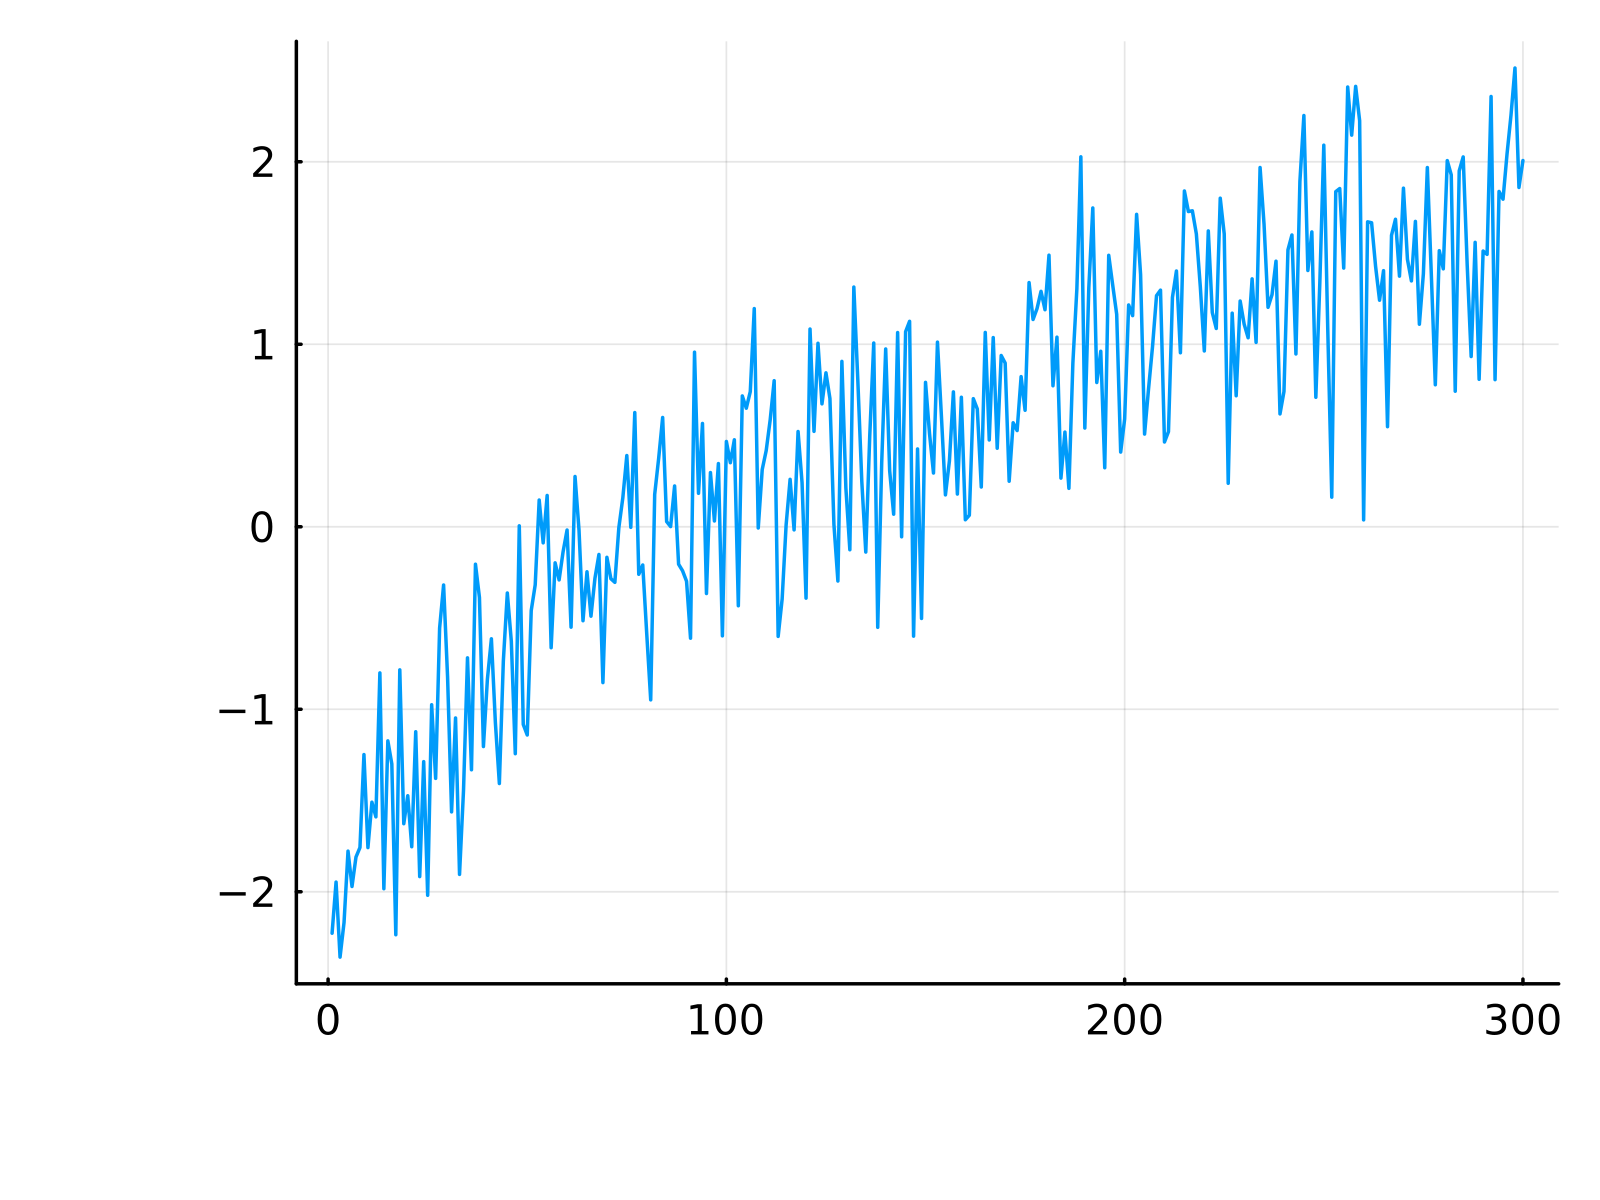

In [13]:
plot(scores, thickness_scaling=3.5, size=(1600, 1200), legend=:none)

Now to test our inference network, we load an observation.

In [14]:
# load the scene from an xml file (instead of a dict)
obs_scene_config = mi.load_file("./scenes/cbox.xml")
obs_scene = ModelParams(scene_d=PyDict(), scene=obs_scene_config, spp=64)
obs_bitmap = render_bitmap(obs_scene)
obs_image = Gen.choicemap()
p = @pycall np.array(obs_bitmap)::Array{Float64, 3}
obs_image[:pred] = p[:, :, 1]
# to view the image on your notebook
obs_bitmap

PyObject Bitmap[
  pixel_format = rgb,
  component_format = float32,
  size = [64, 64],
  srgb_gamma = 1,
  struct = Struct<12>[
    float32 R; // @0, gamma, premultiplied alpha
    float32 G; // @4, gamma, premultiplied alpha
    float32 B; // @8, gamma, premultiplied alpha
  ],
  data = [ 48 KiB of image data ]
]

Next, we downscale this input image and run it through our inference network, and visualize the result. 

Run this block multiple times to get an appreciation for the spread of your variational approximation.

NOTE: You will likely find out that the inference network outputs aren't very accurate. They can be made more accurate with further investment in the architecture of the network and the training set, which are not terribly critical for the present pedagogical context.

In [15]:
# take the first color channel, which is also what we did for training our inference network.
# think of the result as a grayscale image
p_one = p[:, :, 1]
neural_input = imresize(p_one, (12, 12))
neural_input = vec(neural_input[3:10, 3:10])
# get an estimate (sometimes referred to as a bottom-up estimate) using the inference network
bottom_up_trace, _ = Gen.generate(neural_amortized_inference, (neural_input,))
# now call the generative model with this trace to visualize this bottom-up guess
reconstruction, _ = Gen.generate(room, (), Gen.choicemap(get_choices(bottom_up_trace)))
view_image(reconstruction)

PyObject Bitmap[
  pixel_format = rgb,
  component_format = float32,
  size = [64, 64],
  srgb_gamma = 1,
  struct = Struct<12>[
    float32 R; // @0, gamma, premultiplied alpha
    float32 G; // @4, gamma, premultiplied alpha
    float32 B; // @8, gamma, premultiplied alpha
  ],
  data = [ 48 KiB of image data ]
]

# Part III: Iterative inference for further refinement of the posterior

This part follows from the inference procedure of lab-05.

Let's setup a custom proposal on each of the four random variables in our generative model.

And implement the random walk procedure with metropolis-hastings.

In [16]:
# proposal distribution for the scale variables
@gen function custom_proposal(current_trace)
    # trunc_norm(mean, std, lower_bound, upper_bound)
    # why do we need a truncated norm, instead of a regular normal distribution?
    scale_left ~ trunc_norm(current_trace[:scale_left], 0.15, 0., 1.)
    scale_right ~ trunc_norm(current_trace[:scale_right], 0.15, 0., 1.)
    y_coord_left ~ trunc_norm(current_trace[:y_coord_left], 0.15, 0., 1.)
    y_coord_right ~ trunc_norm(current_trace[:y_coord_right], 0.15, 0., 1.)
end
;
function random_walk_mh(tr)
    # make a random-walk update on scale variables
    (tr, accepted) = mh(tr, custom_proposal, ())
    # return the updated trace
    tr
end
;

Now this is where we introduce our bottom-up guess for initialization.

In [17]:
function do_inference()
    K = 20
    # if we were to start from a random place:
    #t, = generate(room, (), obs_image)
    # but we have a better place to start from (based on the inference network):
    t, _ = generate(room, (), Gen.merge(Gen.choicemap(get_choices(bottom_up_trace)), obs_image))
    scores = Vector{Float64}(undef, K)
    @showprogress for i in 1:K
        t = random_walk_mh(t)
        scores[i] = get_score(t)
    end;
    return scores, t
end
;

In [18]:
# call the inference procedure
(scores, t) = do_inference();

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


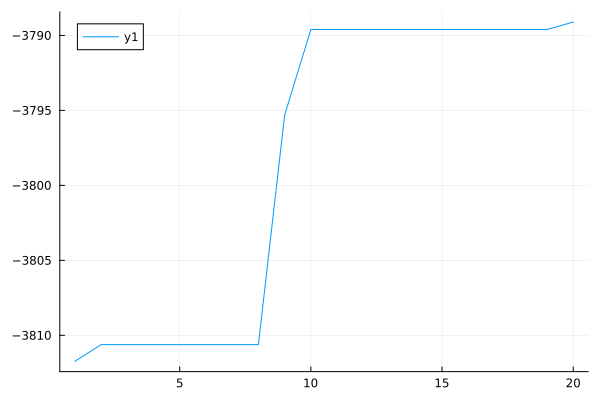

In [19]:
plot(scores, size = (600, 400))

In [20]:
view_image(t)

PyObject Bitmap[
  pixel_format = rgb,
  component_format = float32,
  size = [64, 64],
  srgb_gamma = 1,
  struct = Struct<12>[
    float32 R; // @0, gamma, premultiplied alpha
    float32 G; // @4, gamma, premultiplied alpha
    float32 B; // @8, gamma, premultiplied alpha
  ],
  data = [ 48 KiB of image data ]
]

# Appendix

The following code block was used to generate the dataset for training `neural_amortized_inference`.

```julia
# use the generative model to generate synthetic data
function data_maker()
    let data = Dict()
        @showprogress for k = 1:200
            # simulate data using the prior 
            tr = Gen.simulate(room, ())
            resize_pred = tr[:pred][:, :, 1]
            resize_pred = imresize(resize_pred, (12, 12))
            for name in [:scale_left, :y_coord_left, :scale_right, :y_coord_right]
                data[(k, name)] = tr[name]
            end
            data[(k, :pred)] = resize_pred
            save("dataset/dataset_low_res_new.jld2", "data", data)
        end
    end
end
data_maker()
```